# Butadien II
We will invetigate various Butadien configurations and train a network on it. The data will be solely pyscf generated this time.

In [28]:
plt.style.available

['ggplot',
 'seaborn-muted',
 'seaborn-white',
 '_classic_test',
 'seaborn-ticks',
 'seaborn-paper',
 'seaborn-darkgrid',
 'fast',
 'seaborn-poster',
 'seaborn-dark-palette',
 'seaborn-colorblind',
 'seaborn-whitegrid',
 'classic',
 'dark_background',
 'bmh',
 'seaborn-deep',
 'seaborn-pastel',
 'seaborn-notebook',
 'seaborn-talk',
 'fivethirtyeight',
 'seaborn-bright',
 'seaborn',
 'seaborn-dark',
 'Solarize_Light2',
 'grayscale']

In [1]:
import tensorflow as tf

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


mpl.style.use("seaborn")


dim = 26

#%matplotlib notebook

figures_path = "/home/jo/Repos/MastersThesis/InitialGuess/Butadien/figures/"


/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Creating the dataset

Split: Tresting 25 % (validation 10% and Traning 90%)

In [2]:
S, P = np.load("../data/dataset.npy")
molecules = np.load("../data/molecules.npy")

In [3]:
from SCFInitialGuess.utilities.dataset import Dataset

ind_cut = 150
index = np.arange(200)
np.random.shuffle(index)

S_test = np.array(S)[index[ind_cut:]]
P_test = np.array(P)[index[ind_cut:]]
molecules_test = [molecules[index[i]] for i in range(ind_cut, 200)]

S_train = np.array(S)[index[:ind_cut]]
P_train = np.array(P)[index[:ind_cut]]
molecules_train = [molecules[index[i]] for i in range(ind_cut)]

dataset = Dataset(np.array(S_train), np.array(P_train), split_test=0.0, split_validation=0.1)

dataset.testing = (Dataset.normalize(S_test, mean=dataset.x_mean, std=dataset.x_std)[0], P_test)

[-] 2018-04-15 17:59:51: Data set normalized. Mean value std: 0.008727828391559257


In [4]:
len(dataset.training[0]), len(dataset.validation[0]), len(dataset.testing[0])

(135, 15, 50)

In [5]:
from SCFInitialGuess.nn.networks import EluTrNNN
from SCFInitialGuess.nn.training import train_network
from shutil import rmtree

structure = [dim**2, 600, 600, 600, dim**2]
save_path = "log/plain/"

try:
    sess.close()
except:
    pass

tf.reset_default_graph()
try:
    rmtree(save_path)
except:
    print("could not delete")

network, sess = train_network(
    EluTrNNN(structure, log_histograms=True),
    dataset,
    evaluation_period=100,
    mini_batch_size=20,
    convergence_threshold=1e-7,
    regularisation_parameter=5e-7,
    summary_save_path=save_path
)


[-] 2018-04-15 17:59:51: Setting up the graph ...
[w] 2018-04-15 17:59:53: Careful! If more than 1 network is in current graph, it should be cleared before merging the summary!
[-] 2018-04-15 17:59:53: Starting network training ...
[ ] 2018-04-15 17:59:53: Validation cost: 5.79049E-02. Diff to prev.: 1.0E+10
[ ] 2018-04-15 17:59:55: Validation cost: 1.56704E-04. Diff to prev.: 5.8E-02
[ ] 2018-04-15 17:59:57: Validation cost: 3.54424E-05. Diff to prev.: 1.2E-04
[ ] 2018-04-15 17:59:59: Validation cost: 2.28699E-05. Diff to prev.: 1.3E-05
[ ] 2018-04-15 18:00:01: Validation cost: 1.98584E-05. Diff to prev.: 3.0E-06
[ ] 2018-04-15 18:00:03: Validation cost: 1.36791E-05. Diff to prev.: 6.2E-06
[ ] 2018-04-15 18:00:04: Validation cost: 1.38238E-05. Diff to prev.: 1.4E-07
[ ] 2018-04-15 18:00:06: Validation cost: 1.37054E-05. Diff to prev.: 1.2E-07
[ ] 2018-04-15 18:00:08: Validation cost: 1.62245E-05. Diff to prev.: 2.5E-06
[ ] 2018-04-15 18:00:09: Validation cost: 1.36975E-05. Diff to pre

## Analysis with test data

### Scatter

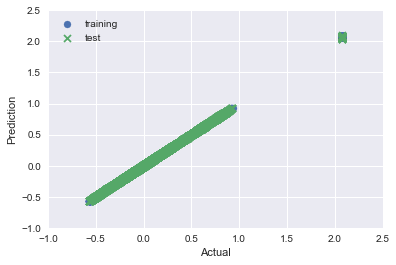

In [25]:
from functools import reduce

flatten = lambda x, y: list(x) + list(y)


#training
expected = reduce(flatten, dataset.training[1])
actual = reduce(flatten, 
    network.run(
        sess, 
        dataset.training[0]
    )
)

frac  = 1
index = np.arange(int(np.floor(frac * len(actual))))
np.random.shuffle(index)
plt.scatter(np.array(expected)[index], np.array(actual)[index], label="training")

# test dataset
expected = reduce(flatten, dataset.testing[1])
actual = reduce(flatten, 
    network.run(
        sess, 
        dataset.testing[0]
    )
)
plt.scatter(expected,actual, marker="x", label="test")

plt.legend()

lower, upper = -1, 2.5
plt.axis([lower, upper, lower, upper])
plt.ylabel("Prediction")
plt.xlabel("Actual")
#plt.savefig(figures_path + "PlainNNScatter.png")
plt.show()

### Accumulated test error matrix

Mean abs. error: 0.0013129091577393926


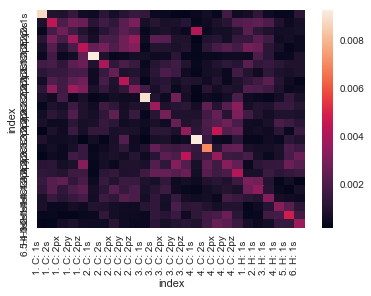

In [7]:
from SCFInitialGuess.utilities.analysis import matrix_error

error = np.zeros((dim, dim))
for (x, y) in zip(*dataset.testing):
    x = x.reshape(1, dim**2)
    error += np.abs((y - network.run(sess, x)).reshape(dim, dim))
error /= len(dataset.testing[0])

print("Mean abs. error: " + str(np.mean(error)))

#%matplotlib notebook

matrix_error(error, ButadienMode=True)
#plt.savefig(figures_path + "MatrixError_NN_absolute.png")
plt.show()

### Iterations

In [45]:
from pyscf.scf import hf

dim = 26

keys = ["H_core", "SAP", "MINAO", "NN", "Converged", "Converged w/ noise"]

iterations = {}
for k in keys:
    iterations[k] = []

for i, (molecule, p) in enumerate(zip(molecules_test, P_test)):
    
    mol = molecule.get_pyscf_molecule()
    
    print("Calculating: " + str(i + 1) + "/" + str(len(molecules_test)))
    
    guesses = {}
    
    # assemble pyscf initial guesses
    guesses["H_core"] = hf.init_guess_by_1e(mol)
    guesses["SAP"] = hf.init_guess_by_atom(mol)
    guesses["MINAO"] = hf.init_guess_by_minao(mol)
    
    # nn guess
    s = hf.get_ovlp(mol).reshape(1, dim**2)
    s = Dataset.normalize(s, mean=dataset.x_mean, std=dataset.x_std)[0]
    guesses["NN"] = network.run(sess, s).reshape(dim, dim).astype('float64')
    
    
    # P_actual wi noise
    guesses["Converged"] = p.reshape(dim, dim)
    guesses["Converged w/ noise"] = p.reshape(dim, dim) + np.random.randn(dim, dim) * 1e-3
    
    
    for (key, guess) in guesses.items():
        mf = hf.RHF(mol)
        mf.diis = None
        mf.max_cycle = 50
        mf.verbose = 1
        mf.kernel(dm0=guess)
        iterations[key].append(mf.iterations)

for k in keys:
    iterations[k] = np.array(iterations[k])

Calculating: 1/50


Warn: Ipython shell catchs sys.args


Calculating: 2/50


Warn: Ipython shell catchs sys.args


Calculating: 3/50


Warn: Ipython shell catchs sys.args


Calculating: 4/50


Warn: Ipython shell catchs sys.args


Calculating: 5/50


Warn: Ipython shell catchs sys.args


Calculating: 6/50


Warn: Ipython shell catchs sys.args


Calculating: 7/50


Warn: Ipython shell catchs sys.args


Calculating: 8/50


Warn: Ipython shell catchs sys.args


Calculating: 9/50


Warn: Ipython shell catchs sys.args


Calculating: 10/50


Warn: Ipython shell catchs sys.args


Calculating: 11/50


Warn: Ipython shell catchs sys.args


Calculating: 12/50


Warn: Ipython shell catchs sys.args


Calculating: 13/50


Warn: Ipython shell catchs sys.args


Calculating: 14/50


Warn: Ipython shell catchs sys.args


Calculating: 15/50


Warn: Ipython shell catchs sys.args


Calculating: 16/50


Warn: Ipython shell catchs sys.args


Calculating: 17/50


Warn: Ipython shell catchs sys.args


Calculating: 18/50


Warn: Ipython shell catchs sys.args


Calculating: 19/50


Warn: Ipython shell catchs sys.args


Calculating: 20/50


Warn: Ipython shell catchs sys.args


Calculating: 21/50


Warn: Ipython shell catchs sys.args


Calculating: 22/50


Warn: Ipython shell catchs sys.args


Calculating: 23/50


Warn: Ipython shell catchs sys.args


Calculating: 24/50


Warn: Ipython shell catchs sys.args


Calculating: 25/50


Warn: Ipython shell catchs sys.args


Calculating: 26/50


Warn: Ipython shell catchs sys.args


Calculating: 27/50


Warn: Ipython shell catchs sys.args


Calculating: 28/50


Warn: Ipython shell catchs sys.args


Calculating: 29/50


Warn: Ipython shell catchs sys.args


Calculating: 30/50


Warn: Ipython shell catchs sys.args


Calculating: 31/50


Warn: Ipython shell catchs sys.args


Calculating: 32/50


Warn: Ipython shell catchs sys.args


Calculating: 33/50


Warn: Ipython shell catchs sys.args


Calculating: 34/50


Warn: Ipython shell catchs sys.args


Calculating: 35/50


Warn: Ipython shell catchs sys.args


Calculating: 36/50


Warn: Ipython shell catchs sys.args


Calculating: 37/50


Warn: Ipython shell catchs sys.args


Calculating: 38/50


Warn: Ipython shell catchs sys.args


Calculating: 39/50


Warn: Ipython shell catchs sys.args


Calculating: 40/50


Warn: Ipython shell catchs sys.args


Calculating: 41/50


Warn: Ipython shell catchs sys.args


Calculating: 42/50


Warn: Ipython shell catchs sys.args


Calculating: 43/50


Warn: Ipython shell catchs sys.args


Calculating: 44/50


Warn: Ipython shell catchs sys.args


Calculating: 45/50


Warn: Ipython shell catchs sys.args


Calculating: 46/50


Warn: Ipython shell catchs sys.args


Calculating: 47/50


Warn: Ipython shell catchs sys.args


Calculating: 48/50


Warn: Ipython shell catchs sys.args


Calculating: 49/50


Warn: Ipython shell catchs sys.args


Calculating: 50/50


Warn: Ipython shell catchs sys.args


In [46]:
for key, val in iterations.items():
    print(key + ": " + str(val.mean()) + " +- " + str(val.std()))

H_core: 50.0 +- 0.0
SAP: 15.14 +- 1.98
MINAO: 13.94 +- 2.4282503989498285
NN: 12.88 +- 2.7249954128401757
Converged: 1.0 +- 0.0
Converged w/ noise: 9.88 +- 1.5702229141112418


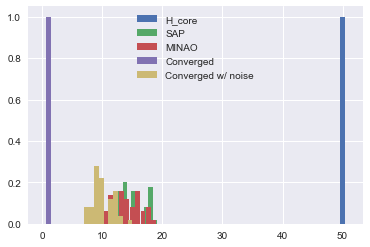

In [10]:
from SCFInitialGuess.utilities.analysis import iterations_histogram

def norm_hist(x):
    return x / np.sum(x)

for key in ["H_core", "SAP", "MINAO", "Converged", "Converged w/ noise"]:
    val = iterations[key]
    hist, bins = np.histogram(val)
    
    center = (bins[:-1] + bins[1:]) / 2
    #axes[i].bar(center, hist, label=name)
    
    plt.bar(center, norm_hist(hist), label=key)
    
plt.legend()

plt.show()

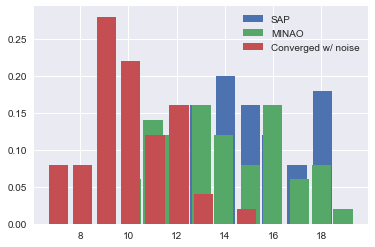

In [26]:
from SCFInitialGuess.utilities.analysis import iterations_histogram

def norm_hist(x):
    return x / np.sum(x)

for key in ["SAP", "MINAO", "Converged w/ noise"]:
    val = iterations[key]
    hist, bins = np.histogram(val, bins=40)
    
    center = (bins[:-1] + bins[1:]) / 2
    #axes[i].bar(center, hist, label=name)
    
    plt.bar(center, norm_hist(hist), label=key)
    
plt.legend()
plt.savefig(figures_path + "IterationsHistogramClassics.png")
plt.show()

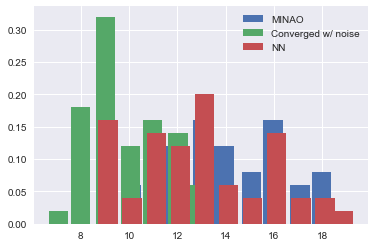

In [49]:
from SCFInitialGuess.utilities.analysis import iterations_histogram

def norm_hist(x):
    return x / np.sum(x)

for key in ["MINAO", "Converged w/ noise", "NN"]:
    val = iterations[key]
    hist, bins = np.histogram(val, bins=40)
    
    center = (bins[:-1] + bins[1:]) / 2
    #axes[i].bar(center, hist, label=name)
    
    plt.bar(center, norm_hist(hist), label=key)
    
plt.legend()
plt.savefig(figures_path + "IterationsHistogramPlain.png")
plt.show()

### Comparing the others against the result
TODO: matrix plot von fehler der jeweiligen initial guesses

In [42]:
from pyscf.scf import hf

dim = 26


number_of_samples = len(S_test)

dP_1e, dP_atom, dP_minao, dP_NN = [np.zeros((dim, dim)) for i in range(4)]
dP_1e_avg, dP_atom_avg, dP_minao_avg, dP_NN_avg = [[] for i in range(4)]

P_1e, P_atom, P_minao, P_expected = [[] for i in range(4)]

for i, (molecule, s, p) in enumerate(zip(molecules_test, S_test, P_test)):
    
    mol = molecule.get_pyscf_molecule()
    
    print("Calculating: " + str(i + 1) + "/" + str(number_of_samples))
    
    # assemble pyscf initial guesses
    P_1e.append(hf.init_guess_by_1e(mol))
    
    P_atom.append(hf.init_guess_by_atom(mol))
    P_minao.append(hf.init_guess_by_minao(mol))
    
    p = p.reshape(dim, dim)
    P_expected.append(p)
    
    
    # nn guess
    s = Dataset.normalize(s.reshape(1, dim**2), mean=dataset.x_mean, std=dataset.x_std)[0]
    P_NN = network.run(sess, s).reshape(dim, dim).astype('float64')
    
    
    # calculate deltas
    dP_1e += np.abs(p - P_1e[-1])
    dP_1e_avg.append(np.mean(np.abs(p - P_1e[-1])))
    
    dP_atom += np.abs(p - P_atom[-1])
    dP_atom_avg.append(np.mean(np.abs(p - P_atom[-1])))
        
    dP_minao += np.abs(p - P_minao[-1])
    dP_minao_avg.append(np.mean(np.abs(p - P_minao[-1])))
    
    dP_NN += np.abs(p - P_NN)
    dP_NN_avg.append(np.mean(np.abs(p - P_NN)))

dP_1e_avg = np.array(dP_1e_avg)
dP_atom_avg = np.array(dP_atom_avg)
dP_minao_avg = np.array(dP_minao_avg)
dP_NN_avg = np.array(dP_NN_avg)

    
dP_1e /= number_of_samples
dP_atom /= number_of_samples
dP_minao /= number_of_samples
dP_NN /= number_of_samples

Calculating: 1/50
Calculating: 2/50


Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args


Calculating: 3/50
Calculating: 4/50


Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args


Calculating: 5/50
Calculating: 6/50


Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args


Calculating: 7/50
Calculating: 8/50


Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args


Calculating: 9/50
Calculating: 10/50


Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args


Calculating: 11/50
Calculating: 12/50


Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args


Calculating: 13/50
Calculating: 14/50
Calculating: 15/50


Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args


Calculating: 16/50
Calculating: 17/50


Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args


Calculating: 18/50
Calculating: 19/50


Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args


Calculating: 20/50
Calculating: 21/50


Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args


Calculating: 22/50


Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args


Calculating: 23/50
Calculating: 24/50
Calculating: 25/50


Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args


Calculating: 26/50
Calculating: 27/50


Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args


Calculating: 28/50
Calculating: 29/50


Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args


Calculating: 30/50
Calculating: 31/50


Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args


Calculating: 32/50
Calculating: 33/50


Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args


Calculating: 34/50
Calculating: 35/50


Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args


Calculating: 36/50
Calculating: 37/50


Warn: Ipython shell catchs sys.args


Calculating: 38/50
Calculating: 39/50


Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args


Calculating: 40/50
Calculating: 41/50


Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args


Calculating: 42/50


Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args


Calculating: 43/50
Calculating: 44/50
Calculating: 45/50


Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args


Calculating: 46/50
Calculating: 47/50


Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args


Calculating: 48/50
Calculating: 49/50


Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args


Calculating: 50/50


Warn: Ipython shell catchs sys.args


In [44]:
print("1e:    {:5.4f} +- {:5.4f}".format(np.mean(dP_1e_avg), np.std(dP_1e_avg)))
print("atom:  {:5.4f} +- {:5.4f}".format(np.mean(dP_atom_avg), np.std(dP_atom_avg)))
print("minao: {:5.4f} +- {:5.4f}".format(np.mean(dP_minao_avg), np.std(dP_minao_avg)))
print("NN:    {:5.4f} +- {:5.4f}".format(np.mean(dP_NN_avg), np.std(dP_NN_avg)))

1e:    0.3247 +- 0.0150
atom:  0.0909 +- 0.0005
minao: 0.0826 +- 0.0006
NN:    0.0013 +- 0.0003


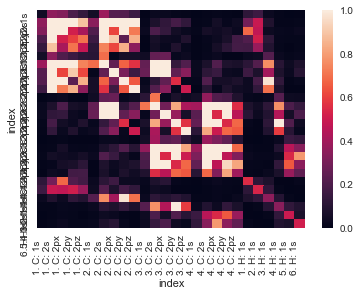

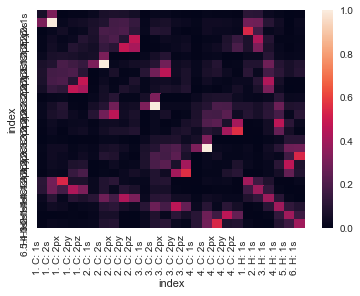

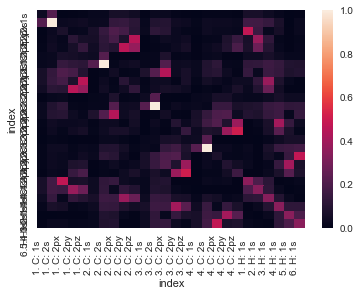

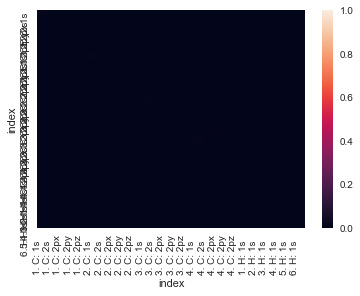

In [14]:
import matplotlib
#%matplotlib notebook
title = ["H_core", "SAP", "MINAO", "NN"]
norm = None
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
for i, error in enumerate([dP_1e, dP_atom, dP_minao, dP_NN]):
    plt.figure()
    #plt.title(title[i])
    matrix_error(error, vmin=0, vmax=1, ButadienMode=True)
    #plt.savefig(figures_path + "MatrixError_" + title[i] + ".png")
#plt.show()   

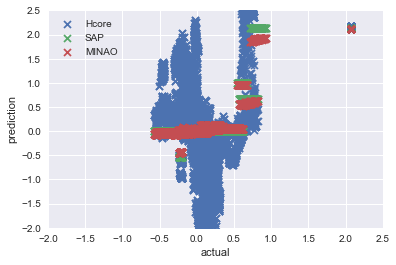

In [27]:
flatten = lambda x, y: list(x) + list(y)

def transform(x):
    return reduce(flatten, map(lambda y: y.flatten(), x))

fig = plt.figure()

expected = transform(P_expected)
labels = ["Hcore", "SAP", "MINAO"]
for i, guess in enumerate(map(transform, [P_1e, P_atom, P_minao])):
    
    #fig = plt.figure()
    plt.scatter(expected, guess, marker="x", label=labels[i])
    plt.ylabel("prediction")
    plt.xlabel("actual")
    #plt.axis('equal')
    #plt.set_aspect('equal', 'box')
    lower, upper = -2, 2.5
    plt.axis([lower, upper, lower, upper])
    #plt.title(labels[i])
    
plt.legend()    

#fig.savefig(figures_path + "ClassicsScatter.png")
plt.show()

## Check: was the calculation consistent?
Comapre newly calculated p vs P_test.

In [16]:
from pyscf.scf import hf

dim = 26

number_of_samples = len(S_test)

dP = np.zeros((dim, dim))

for i, (molecule, p) in enumerate(zip(molecules_test, P_test)):
    
    mol = molecule.get_pyscf_molecule()
    
    print("Calculating: " + str(i + 1) + "/" + str(number_of_samples))
    
    mf = hf.RHF(mol)
    mf.verbose = 1
    mf.kernel()
    
    p = p.reshape(dim, dim)
    
    dP += np.abs(p - mf.make_rdm1())

dP /= number_of_samples


Warn: Ipython shell catchs sys.args


Calculating: 1/50


Warn: Ipython shell catchs sys.args


Calculating: 2/50


Warn: Ipython shell catchs sys.args


Calculating: 3/50


Warn: Ipython shell catchs sys.args


Calculating: 4/50


Warn: Ipython shell catchs sys.args


Calculating: 5/50


Warn: Ipython shell catchs sys.args


Calculating: 6/50


Warn: Ipython shell catchs sys.args


Calculating: 7/50


Warn: Ipython shell catchs sys.args


Calculating: 8/50


Warn: Ipython shell catchs sys.args


Calculating: 9/50


Warn: Ipython shell catchs sys.args


Calculating: 10/50


Warn: Ipython shell catchs sys.args


Calculating: 11/50


Warn: Ipython shell catchs sys.args


Calculating: 12/50


Warn: Ipython shell catchs sys.args


Calculating: 13/50


Warn: Ipython shell catchs sys.args


Calculating: 14/50


Warn: Ipython shell catchs sys.args


Calculating: 15/50


Warn: Ipython shell catchs sys.args


Calculating: 16/50


Warn: Ipython shell catchs sys.args


Calculating: 17/50


Warn: Ipython shell catchs sys.args


Calculating: 18/50


Warn: Ipython shell catchs sys.args


Calculating: 19/50


Warn: Ipython shell catchs sys.args


Calculating: 20/50


Warn: Ipython shell catchs sys.args


Calculating: 21/50


Warn: Ipython shell catchs sys.args


Calculating: 22/50


Warn: Ipython shell catchs sys.args


Calculating: 23/50


Warn: Ipython shell catchs sys.args


Calculating: 24/50


Warn: Ipython shell catchs sys.args


Calculating: 25/50


Warn: Ipython shell catchs sys.args


Calculating: 26/50


Warn: Ipython shell catchs sys.args


Calculating: 27/50


Warn: Ipython shell catchs sys.args


Calculating: 28/50


Warn: Ipython shell catchs sys.args


Calculating: 29/50


Warn: Ipython shell catchs sys.args


Calculating: 30/50


Warn: Ipython shell catchs sys.args


Calculating: 31/50


Warn: Ipython shell catchs sys.args


Calculating: 32/50


Warn: Ipython shell catchs sys.args


Calculating: 33/50


Warn: Ipython shell catchs sys.args


Calculating: 34/50


Warn: Ipython shell catchs sys.args


Calculating: 35/50


Warn: Ipython shell catchs sys.args


Calculating: 36/50


Warn: Ipython shell catchs sys.args


Calculating: 37/50


Warn: Ipython shell catchs sys.args


Calculating: 38/50


Warn: Ipython shell catchs sys.args


Calculating: 39/50


Warn: Ipython shell catchs sys.args


Calculating: 40/50


Warn: Ipython shell catchs sys.args


Calculating: 41/50


Warn: Ipython shell catchs sys.args


Calculating: 42/50


Warn: Ipython shell catchs sys.args


Calculating: 43/50


Warn: Ipython shell catchs sys.args


Calculating: 44/50


Warn: Ipython shell catchs sys.args


Calculating: 45/50


Warn: Ipython shell catchs sys.args


Calculating: 46/50


Warn: Ipython shell catchs sys.args


Calculating: 47/50


Warn: Ipython shell catchs sys.args


Calculating: 48/50


Warn: Ipython shell catchs sys.args


Calculating: 49/50


Warn: Ipython shell catchs sys.args


Calculating: 50/50


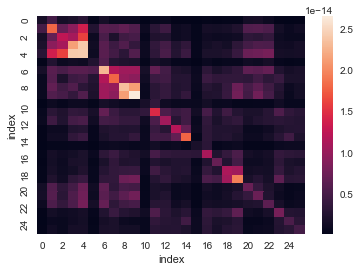

In [17]:
plt.figure()
matrix_error(dP)
plt.show()

## Physically motivated output activations
As we suspect the high number of iterations may be due to pysically to unphysical values. Thus we willtransform the output.

### Sigmoid
We will now try $\sigma(x) * 2$ to frce the values to be be between 1 and 2.

In [18]:
from SCFInitialGuess.nn.training import train_network
from SCFInitialGuess.nn.networks import EluTrNNN
import tensorflow as tf

class EluTrNNNSigmoid(EluTrNNN):
    def _output_activation(self, preactivation):
        """Sigmoidal output activation."""
        return tf.nn.sigmoid(preactivation) * 4 - 2

structure = [dim**2, 200, 100, dim**2]


#tf.reset_default_graph()
sigmoid_nn, sess_sigmoid = train_network(
    EluTrNNNSigmoid(structure),
    dataset,
    evaluation_period=100,
    mini_batch_size=20,
    convergence_threshold=1e-5,
    regularisation_parameter=1e-8
)

[-] 2018-04-15 18:02:59: Setting up the graph ...
[-] 2018-04-15 18:02:59: Starting network training ...
[ ] 2018-04-15 18:02:59: Validation cost: 5.77238E-02. Diff to prev.: 1.0E+10
[ ] 2018-04-15 18:02:59: Validation cost: 3.70773E-04. Diff to prev.: 5.7E-02
[ ] 2018-04-15 18:03:00: Validation cost: 1.60868E-04. Diff to prev.: 2.1E-04
[ ] 2018-04-15 18:03:00: Validation cost: 1.02747E-04. Diff to prev.: 5.8E-05
[ ] 2018-04-15 18:03:00: Validation cost: 7.40761E-05. Diff to prev.: 2.9E-05
[ ] 2018-04-15 18:03:01: Validation cost: 6.29870E-05. Diff to prev.: 1.1E-05
[-] 2018-04-15 18:03:01: Convergence reached after 600 steps.
[-] 2018-04-15 18:03:01: Test error: 5.87271E-05


### McWheene Matrix Purification.
We will try the McWheene transformation 

$$P \rightarrow 3P^2 - 2P^3 $$

as output activation. This transformation is used to force idempotence upon the density matrix.

In [19]:
from SCFInitialGuess.nn.training import train_network
from SCFInitialGuess.nn.networks import EluTrNNN
import tensorflow as tf

class EluTrNNNMcWheene(EluTrNNN):
    def _output_activation(self, preactivation):
        """McWheene output transformation used as activaton."""
        
        reshaped_pre = tf.reshape(preactivation, shape=[-1, dim, dim])
    
        # if 3D tensor and dims match, tf will ignore first dim!
        squared = tf.matmul(
            reshaped_pre, 
            reshaped_pre
        )
        
        cubed = tf.matmul(
            squared,
            reshaped_pre
        )
        
        out = 3 * squared - 2 * cubed
        
        return tf.reshape(out, shape=[-1, dim**2])

structure = [dim**2, 200, 100, dim**2]

#tf.reset_default_graph()
mcwheene_nn, sess_mcwheeny = train_network(
    EluTrNNNMcWheene(structure),
    dataset,
    evaluation_period=100,
    mini_batch_size=20,
    convergence_threshold=1e-5,
    regularisation_parameter=1e-6
)

[-] 2018-04-15 18:03:01: Setting up the graph ...
[-] 2018-04-15 18:03:01: Starting network training ...
[ ] 2018-04-15 18:03:01: Validation cost: 5.77330E-02. Diff to prev.: 1.0E+10
[ ] 2018-04-15 18:03:02: Validation cost: 4.86063E-03. Diff to prev.: 5.3E-02
[ ] 2018-04-15 18:03:02: Validation cost: 2.08891E-03. Diff to prev.: 2.8E-03
[ ] 2018-04-15 18:03:02: Validation cost: 1.05210E-03. Diff to prev.: 1.0E-03
[ ] 2018-04-15 18:03:03: Validation cost: 8.43690E-04. Diff to prev.: 2.1E-04
[-] 2018-04-15 18:03:03: Convergence reached after 500 steps.
[-] 2018-04-15 18:03:03: Test error: 1.83947E-03


### Analysis


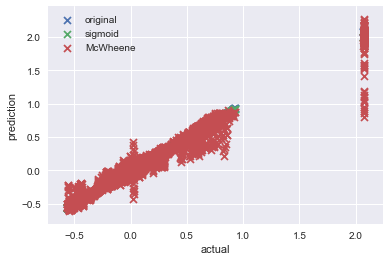

In [20]:
# test dataset

#original network
plt.scatter(
    np.array(dataset.testing[1]).flatten(),
    np.array(
        network.run(
            sess, 
            dataset.testing[0]
        )
    ).flatten(), 
    marker="x", 
    label="original"
)

# sigmoid
plt.scatter(
    np.array(dataset.testing[1]).flatten(),
    np.array(
        sigmoid_nn.run(
            sess_sigmoid, 
            dataset.testing[0]
        )
    ).flatten(), 
    marker="x", 
    label="sigmoid"
)

# mcwheene
plt.scatter(
    np.array(dataset.testing[1]).flatten(),
    np.array(
        mcwheene_nn.run(
            sess_mcwheeny, 
            dataset.testing[0]
        )
    ).flatten(), 
    marker="x", 
    label="McWheene"
)


plt.legend()

#lower, upper = -1, 2.5
#plt.axis([lower, upper, lower, upper])
plt.ylabel("prediction")
plt.xlabel("actual")
plt.show()

In [21]:
from pyscf.scf import hf

dim = 26

iterations_output_activations = []
for i, molecule in enumerate(molecules_test):
    
    mol = molecule.get_pyscf_molecule()
    
    
    print("Calculating: " + str(i + 1) + "/" + str(len(molecules_test)))
    
    # nn guess
    s = hf.get_ovlp(mol).reshape(1, dim**2)
    s = Dataset.normalize(s, mean=dataset.x_mean, std=dataset.x_std)[0]
    P_Sigmoid = sigmoid_nn.run(sess, s).reshape(dim, dim).astype('float64')
    P_McWheene = mcwheene_nn.run(sess, s).reshape(dim, dim).astype('float64')
        
    iterations_molecule = []
    for guess in [P_Sigmoid, P_McWheene]:
        
        mf = hf.RHF(mol)
        mf.verbose = 1
        mf.kernel(dm0=guess)
        iterations_molecule.append(mf.iterations)
    
    iterations_output_activations.append(iterations_molecule)

iterations_output_activations = np.array(iterations_output_activations)

Warn: Ipython shell catchs sys.args


Calculating: 1/50


FailedPreconditionError: Attempting to use uninitialized value output_layer_1/b
	 [[Node: output_layer_1/b/read = Identity[T=DT_FLOAT, _class=["loc:@output_layer_1/b"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](output_layer_1/b)]]

Caused by op 'output_layer_1/b/read', defined at:
  File "/home/jo/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/jo/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/jo/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jo/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/home/jo/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jo/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/jo/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jo/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/jo/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/jo/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/jo/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jo/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/jo/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/jo/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/jo/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/jo/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/jo/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/jo/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/jo/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-bb74ce4bc465>", line 20, in <module>
    regularisation_parameter=1e-8
  File "/home/jo/Repos/SCFInitialGuess/SCFInitialGuess/nn/training.py", line 285, in train_network
    network_output = network.setup()
  File "/home/jo/Repos/SCFInitialGuess/SCFInitialGuess/nn/networks.py", line 93, in setup
    self.structure[-1]
  File "/home/jo/Repos/SCFInitialGuess/SCFInitialGuess/nn/networks.py", line 145, in _add_output_layer
    name="b"
  File "/home/jo/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 233, in __init__
    constraint=constraint)
  File "/home/jo/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 381, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/home/jo/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 131, in identity
    return gen_array_ops.identity(input, name=name)
  File "/home/jo/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2051, in identity
    "Identity", input=input, name=name)
  File "/home/jo/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/jo/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3271, in create_op
    op_def=op_def)
  File "/home/jo/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1650, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value output_layer_1/b
	 [[Node: output_layer_1/b/read = Identity[T=DT_FLOAT, _class=["loc:@output_layer_1/b"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](output_layer_1/b)]]


In [ ]:
#fig, axes = plt.subplots(2,2)

print(np.mean(iterations_output_activations,0))

bins = 20 # todo hier kann man auch ein array angeben

for i, name in enumerate(["Sigmoid", "McWheene"]):
    
    hist, bins = np.histogram(iterations_output_activations[:,i])
    center = (bins[:-1] + bins[1:]) / 2
    #axes[i].bar(center, hist, label=name)
    plt.bar(center, hist, label=name)
    
plt.legend()
plt.show()

In [ ]:
str(tf.get_default_graph())